In [158]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate, create_grid
from src.interpolate import *
from src.emfiles import load_data,crop_fourier_images
from src.jaxops import *
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
import mrcfile

### Read the data

In [3]:
data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

imgs_f, params = load_data(data_dir, star_file)
ctf_params = params["ctf_params"]
pixel_size = params["pixel_size"]
angles = params["angles"]
shifts = params["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


load_data: number of partcles:  39972
load_data: data loaded, time:  79.8039665222168
load_data: FFT of data, time:  108.53554511070251


(39972, 308, 308)
(39972,)
(39972, 3)
(39972, 2)
(39972, 9)


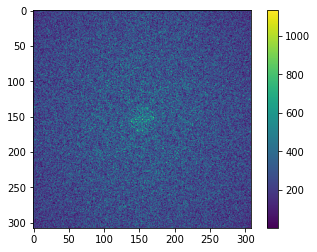

In [4]:
print(imgs_f.shape)
print(pixel_size.shape)
print(angles.shape)
print(shifts.shape)
print(ctf_params.shape)

plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101]))); plt.colorbar()

### Create the grids

In [5]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.90704362e-03 3.08000000e+02]


### Crop images to 64 x 64 

In [6]:
nx = 64
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.90704362e-03 6.40000000e+01]


### Before further processing, vectorize the images, create mask etc

In [91]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(39972, 4096)


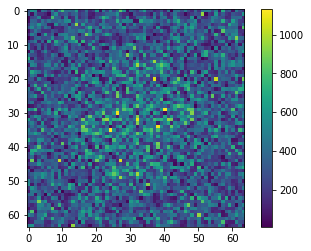

In [92]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

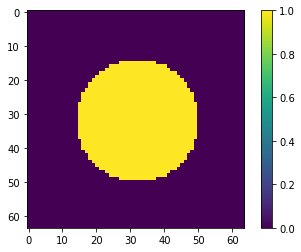

In [137]:
centre = (0,0,0)
radius = 0.07

mask = create_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [207]:
alpha = 0.1

slice_func, slice_func_array = get_slice_funcs(project, x_grid, y_grid, z_grid, "tri")
loss_func, loss_func_sum = get_loss_funcs(slice_func, alpha)

In [208]:
@jax.jit
def grad_loss_volume(v, angles, shifts, ctf_params, img):
    return jax.grad(loss_func)(v, angles, shifts, ctf_params, img)

@jax.jit
def grad_loss_volume_batched(v, angles, shifts, ctf_params, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs), axis=0)

@jax.jit
def grad_loss_volume_sum(v, angles, shifts, ctf_params, imgs):
    return jax.grad(loss_func_sum)(v, angles, shifts, ctf_params, imgs)



Test the functions above with a random volume

In [209]:
vf = jnp.array(np.random.randn(nx,nx,nx))

In [210]:
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(4096,)

In [211]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

1.2922427654266357
(64, 64, 64)


In [212]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

1.3611810207366943
(64, 64, 64)


### CG

In [213]:
from src.algorithm import conjugate_gradient

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 50
zero = jnp.zeros(v0.shape).astype(jnp.complex64)

Abfun = grad_loss_volume_sum(zero, angles, shifts, ctf_params, imgs_f)
Ab = - jnp.conj(Abfun)
AA = lambda vv : jnp.conj(grad_loss_volume_sum(vv, angles, shifts, ctf_params, imgs_f)) + Ab

vcg, max_iter = conjugate_gradient(AA, Ab, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.03673675852533827
Iter 1 ||r|| = 0.016051005021651472
Iter 2 ||r|| = 0.022742069534924723
Iter 3 ||r|| = 0.016691460132690652
Iter 4 ||r|| = 0.008225573765749082
Iter 5 ||r|| = 0.004494662905721981
Iter 6 ||r|| = 0.025273434227460666
Iter 7 ||r|| = 0.024424985434787785
Iter 8 ||r|| = 0.02365415853490218
Iter 9 ||r|| = 0.022992867545182094
Iter 10 ||r|| = 0.022458495702119188
Iter 11 ||r|| = 0.022052952319987374
Iter 12 ||r|| = 0.021762849939729396
Iter 13 ||r|| = 0.02156084333473732
Iter 14 ||r|| = 0.021408492688780922
Iter 15 ||r|| = 0.021261146121678388
Iter 16 ||r|| = 0.02107500547515539
Iter 17 ||r|| = 0.020815607946797536
Iter 18 ||r|| = 0.02046572552822181
Iter 19 ||r|| = 0.020029993628739997
Iter 20 ||r|| = 0.019534289071564945
Iter 21 ||r|| = 0.0190199224519538
Iter 22 ||r|| = 0.018534831537337274
Iter 23 ||r|| = 0.018124753844572756
Iter 24 ||r|| = 0.017826548339106407
Iter 25 ||r|| = 0.017664331460081832
Iter 26 ||r|| = 0.017647942333490024
Iter 27 ||r|| = 0.

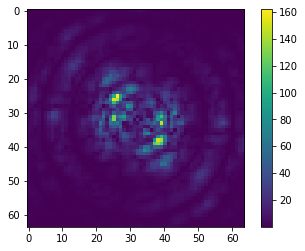

In [214]:
i = 1110
s0 = slice_func(vcg, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

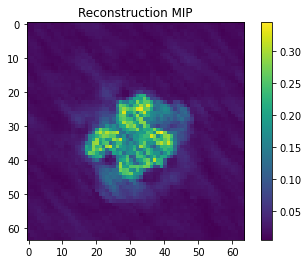

In [215]:
mip_x(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [148]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))) 

In [149]:
vr.shape

(64, 64, 64)

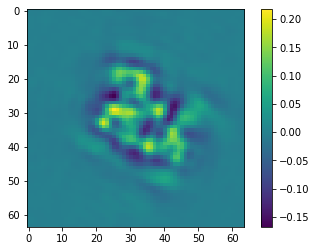

In [150]:
plt.imshow(vr[:,:,32]); plt.colorbar()

### Write volume to file

In [151]:
#with mrcfile.new('../data/reconstruction_c.mrc', overwrite=True) as mrc:
#    mrc.set_data(vr.astype(np.float32))